In [ ]:
%reload_ext watermark
%watermark -v -m -p numpy,matplotlib,sklearn,pandas,torch,transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load Data

In [ ]:
# load data
train_df = pd.read_csv('data/train_split.tsv', sep='\t')
test_df = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['text', 'label'])
val_df = pd.read_csv('data/val_split.tsv', sep='\t')

# test_df.head()
train_df.head()

In [ ]:
imdb_train_df = pd.read_csv('data/train_imdb_split.csv')
imdb_val_df = pd.read_csv('data/val_imdb_split.csv')
imdb_test_df = pd.read_csv('data/test_imdb_split.csv')

imdb_train_df.head()

### Model

In [ ]:
import torch
import torch.nn as nn

class MLP_Model(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(MLP_Model, self).__init__()

        self.layers = nn.ModuleDict({
            "Layer 1": nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 2": nn.Sequential(
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 3": nn.Sequential(
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 4": nn.Sequential(
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 5": nn.Linear(hidden_sizes[3], output_size)
        })

    def forward(self, x):
        for name, layer in self.layers.items():
            x = layer(x)
        return x

model = MLP_Model()
print(model)

In [ ]:
sum_params = 0

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Params: {param.numel()} | Trainable: {param.requires_grad}')
    if param.requires_grad:
        sum_params += param.numel()

print(f'Total Trainable Parameters: {sum_params}')

### Bag-of-words

The bag-of-words model (BoW) is a model of text which uses an unordered collection (a "bag") of words. It disregards word order (and thus most of syntax or grammar) but captures multiplicity.

Each key is the word, and each value is the number of occurrences of that word in the given text document.

```javascript
(1) John likes to watch movies. Mary likes movies too.

(2) Mary also likes to watch football games.
```

Based on these two text documents, a list is constructed as follows for each document:

```javascript
"John","likes","to","watch","movies","Mary","likes","movies","too"

"Mary","also","likes","to","watch","football","games"
```

Representing each bag-of-words as a JSON object, and attributing to the respective JavaScript variable:

```javascript
BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};

BoW2 = {"Mary":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1};
```

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = TextDataset(val_df["text"].tolist(), val_df["label"].tolist())
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist())

In [ ]:
# Batch size
BATCH_SIZE = 32

# Fit CountVectorizer on training data
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_df["text"])

# Collate function for BoW
def bow_collate_fn(batch):
    texts, labels = zip(*batch)  # Unpack batch into texts and labels
    X_batch = vectorizer.transform(texts).toarray()  # Vectorize texts using BoW
    X_batch_tensor = torch.tensor(X_batch, dtype=torch.float32)  # Convert to tensor
    y_batch_tensor = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor (for classification tasks)
    return X_batch_tensor, y_batch_tensor

# Create DataLoaders for BoW
train_loader_bow = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow)}")
print(f"Number of validation batches: {len(val_loader_bow)}")
print(f"Number of test batches: {len(test_loader_bow)}")


In [ ]:
import numpy as np

# Map word indices to words
word2idx = vectorizer.vocabulary_
idx2word = {v: k for k, v in word2idx.items()}

sample_number = 5 

# Take a specific sample from the validation DataFrame
val_text_sample = val_df.text.iloc[sample_number]  # Select the sample from validation set
val_label_sample = val_df.label.iloc[sample_number]  # Get the corresponding label
print("Original Sentence:", val_text_sample.split())
print("Original sentence label:", val_label_sample)

# Get the first batch from val_loader_bow
X_batch, y_batch = next(iter(val_loader_bow))  # Get the first batch from DataLoader

# Extract the specific sample from the first batch
X_bow_sample = X_batch[sample_number]
y_bow_sample = y_batch[sample_number]

# Print BoW representation details
print("BoW representation shape:", X_bow_sample.shape)
print("BoW representation:", X_bow_sample)

# Find non-zero indices in the BoW representation
nonzero_indices = torch.nonzero(X_bow_sample).flatten().numpy()  # Non-zero indices correspond to words present in the sentence
print("Non-zero indices:", nonzero_indices)

# Map non-zero indices back to words using idx2word
words_in_sentence = [idx2word[idx] for idx in nonzero_indices]
print("Words in BoW representation:", words_in_sentence)

# Compare with original sentence (sorted)
original_words_sorted = sorted(val_text_sample.split())
print("Original words in sentence (sorted):", original_words_sorted)

# Print lengths for comparison
print("Length of original sentence:", len(original_words_sorted))
print("Length of BoW-represented words:", len(words_in_sentence))


###  Embedding Model bert-base-uncased

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from transformers import AutoTokenizer, AutoModel

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

bert = AutoModel.from_pretrained(model_name)

embedding_size = bert.config.hidden_size
print('Embedding size:',embedding_size)

In [ ]:
bert.eval()
bert.to(device)

text = 'hello world'
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
print(inputs['input_ids'])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

with torch.no_grad():
    outputs = bert(**inputs.to(device))

embeddings = outputs.last_hidden_state
print('First id:',inputs['input_ids'][0][1])
print('First token:',tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1])
print('Embedding shape:',embeddings.shape)


sentence_embeddings = torch.mean(embeddings, dim=1)
print('Sentence embedding shape:',sentence_embeddings.shape)

# CLS : first token, SEP : last token

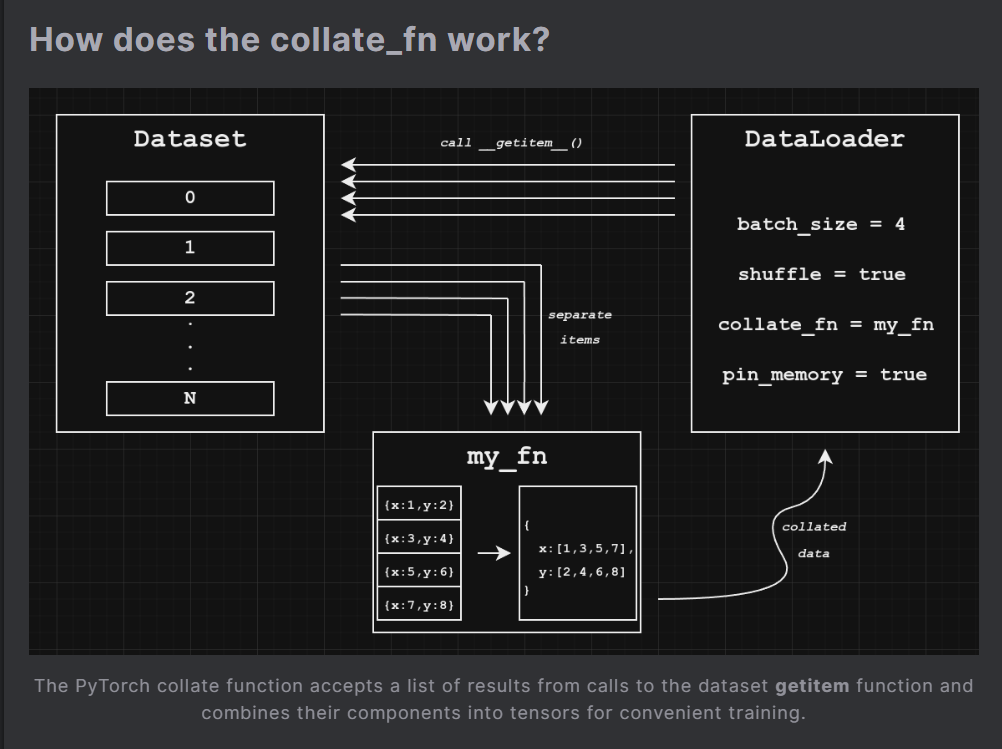

In [ ]:
def get_bert_embeddings(inputs, bert, pooling_strategy='mean'):
    with torch.no_grad():
        outputs = bert(**inputs)
        
    embeddings = outputs.last_hidden_state
    
    if pooling_strategy == 'mean':
        sentence_embeddings = torch.mean(embeddings, dim=1)  # Mean pooling
    elif pooling_strategy == 'max':
        sentence_embeddings = torch.max(embeddings, dim=1).values  # Max pooling
    elif pooling_strategy == 'cls':
        sentence_embeddings = embeddings[:, 0, :]  # CLS token
    elif pooling_strategy == 'sep':
        sentence_embeddings = embeddings[:, -1, :]  # SEP token
    else:
        raise ValueError("Pooling strategy not valid")

    return sentence_embeddings

def bert_collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = None
    if isinstance(batch[0], tuple) and len(batch[0]) > 1:
        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    sentence_embeddings = get_bert_embeddings(inputs, bert, pooling_strategy=pooling_strategy)

    return sentence_embeddings.cpu() , labels

BATCH_SIZE = 32
pooling_strategy = 'mean'  

train_loader_bert = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_fn)
val_loader_bert = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)
test_loader_bert = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)

print(f"Number of training batches: {len(train_loader_bert)}")
print(f"Number of validation batches: {len(val_loader_bert)}")
print(f"Number of test batches: {len(test_loader_bert)}")

In [ ]:
# first sample from first batch of validation loader
X_bert_sample, y_bert_sample = next(iter(val_loader_bert))
print("BERT representation shape:", X_bert_sample.shape)
print("BERT representation:", X_bert_sample[0])
print("BERT representation label:", y_bert_sample[0])

### Training on Dataset I

In [ ]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn
import time
import os

def save_checkpoint(model, optimizer, epoch, best_acc, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} -> {checkpoint_path}")

def train(model, checkpoint_path, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    model.to(device)
    best_acc = 0
    train_loss_history = []
    val_loss_history = []

    # Load checkpoint if exists
    start_epoch = 1
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        print(f"Resuming from epoch {start_epoch} with best accuracy: {best_acc:.4f}")

    try:
        for epoch in range(start_epoch, num_epochs + 1):
            start_time = time.time()

            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    y_pred_val = model(X_batch)
                    loss = criterion(y_pred_val, y_batch)
                    val_loss += loss.item()

                    y_pred_val_class = torch.argmax(y_pred_val, dim=1)
                    correct += torch.sum(y_pred_val_class == y_batch).item()
                    total += y_batch.size(0)

            val_loss /= len(val_loader)
            val_acc = correct / total

            epoch_time = time.time() - start_time
            print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s')

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)

            # Save checkpoint if accuracy improves
            if val_acc > best_acc:
                best_acc = val_acc
                save_checkpoint(model, optimizer, epoch, best_acc, checkpoint_path)

    except KeyboardInterrupt:
        print("\nTraining interrupted! Saving last model checkpoint...")
        save_checkpoint(model, optimizer, epoch, best_acc, checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}. Exiting.")

    print('Best Val Acc:', best_acc)
    return train_loss_history, val_loss_history


#### Training bow model

In [ ]:
import torch.optim as optim

bow_model = MLP_Model(input_size=10000)
bow_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bow_model,
    'models/bow_1.pt',
    optimizer,
    criterion,
    train_loader_bow,
    val_loader_bow,
    num_epochs,
    device
)

# Plot the training and validation loss history
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Training bert model

In [ ]:
import torch.optim as optim

bert_model = MLP_Model(input_size=embedding_size)
bert_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert_model.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history3, val_loss_history3 = train(
    bert_model,
    'models/bert_1.pt',
    optimizer,
    criterion,
    train_loader_bert,
    val_loader_bert,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history3, label='Train Loss')
plt.plot(epochs, val_loss_history3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Testing on Dataset I

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred_logits = model(X_batch)  # shape: (batch_size, num_classes)
            loss = criterion(y_pred_logits, y_batch)
            test_loss += loss.item()

            # Get predicted labels
            y_pred_labels = torch.argmax(y_pred_logits, dim=1)  # Predicted class indices

            # Collect true and predicted labels for metrics
            all_y_true.extend(y_batch.cpu().numpy())
            all_y_pred.extend(y_pred_labels.cpu().numpy())

    # Average test loss over all batches
    test_loss /= len(test_loader)

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix

accuracy_bow_1, conf_matrix_bow_1 = test(bow_model, criterion, test_loader_bow, device)

In [ ]:
accuracy_bow_3, conf_matrix_bow_3 = test(bert_model, criterion, test_loader_bert, device)

### Training on Dataset II

#### Training bow model 

In [ ]:
train_imdb_dataset = TextDataset(imdb_train_df["text"].tolist(), imdb_train_df["label"].tolist())
val_imdb_dataset = TextDataset(imdb_val_df["text"].tolist(), imdb_val_df["label"].tolist())
test_imdb_dataset = TextDataset(imdb_test_df["text"].tolist(), imdb_test_df["label"].tolist())

train_loader_bow_imdb = DataLoader(train_imdb_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow_imdb = DataLoader(val_imdb_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow_imdb)}")
print(f"Number of validation batches: {len(val_loader_bow_imdb)}")
print(f"Number of test batches: {len(test_loader_bow)}")

In [ ]:
import torch.optim as optim 

# Load the check pointed model
bow_model_2 = MLP_Model(input_size=10000)
bow_model_2.load_state_dict(torch.load('models/bow_1.pt'))
bow_model_2.to(device)

print('model loaded')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model_2.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bow_model_2,
    'models/bow_2.pt',
    optimizer,
    criterion,
    train_loader_bow_imdb,
    val_loader_bow_imdb,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Training bert model

In [ ]:
train_loader_bert_imdb = DataLoader(train_imdb_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_fn)
val_loader_bert_imdb = DataLoader(val_imdb_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bert_collate_fn)
test_loader_bert_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bert_collate_fn)

print(f"Number of training batches: {len(train_loader_bert_imdb)}")
print(f"Number of validation batches: {len(val_loader_bert_imdb)}")
print(f"Number of test batches: {len(test_loader_bert)}")

In [ ]:
import torch.optim as optim 

# Load the check pointed model
bert_model_2 = MLP_Model(input_size=embedding_size)
bert_model_2.load_state_dict(torch.load('models/bert_1.pt'))
bert_model_2.to(device)

print('model loaded')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert_model_2.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bert_model_2,
    'models/bert_2.pt',
    optimizer,
    criterion,
    train_loader_bert_imdb,
    val_loader_bert_imdb,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Testing on Dataset II

In [ ]:
accuracy_bow_2, conf_matrix_bow_2 = test(bow_model_2, criterion, test_loader_bow_imdb, device)